### NetworkX prototype

In [52]:
import networkx as nx
import math

def create_reference_graph(reference, gene):
    """
    Build an undirected graph for the reference genome:
      0 -- 1 -- 2 -- ... -- (n-1)
    Each node is assigned:
      - position: the index
      - nucleotide: the base at that position
      - type: "reference"
    """
    G = nx.Graph()
    for i, base in enumerate(reference):
        G.add_node(
            i,
            position=i,
            nucleotide=base,
            type="reference",
            gene=gene
        )
    for i in range(len(reference) - 1):
        G.add_edge(i, i + 1)
    return G

def add_variant(graph, reference, position, ref_seq, alt_seq, gene, beta=None, p_value=None, strand="+", direction="+"):
    """
    Add one 'bubble' variant node for a mutation at 'position' that replaces ref_seq with alt_seq.
    
    Special handling for p=0:
      - Do NOT add a left edge; the bubble node will be a separate origin.
    Otherwise:
      - Connect (p-1) -> variant_node.
    
    In both cases, if (p + len(ref_seq)) is within the reference,
    add an edge from the variant node -> (p + len(ref_seq)).
    
    The variant node is assigned attributes:
      - ref: reference allele (ref_seq)
      - alt: alternate allele (alt_seq)
      - alt_length: len(alt_seq)
      - ref_length: len(ref_seq)
      - position: starting position (p)
      - beta: provided beta value or None
      - log10(p): computed log10(p_value) if p_value is provided, else None
      - strand: as given (default "+")
      - type: "variant"
      - direction: as given (default "+")
    """
    p = position
    n = len(reference)
    
    # Create a unique node ID for the variant
    var_node_id = f"VAR_{p}_{ref_seq}->{alt_seq}"
    
    # Compute log10(p) if provided
    log10_p = math.log10(p_value) if p_value is not None and p_value > 0 else None
    
    # Add the bubble variant node with the new attributes.
    graph.add_node(
        var_node_id,
        ref=ref_seq,
        alt=alt_seq,
        alt_length=len(alt_seq),
        ref_length=len(ref_seq),
        position=p,
        beta=beta,
        log10_p=log10_p,
        strand=strand,
        type="variant",
        direction=direction,
        gene=gene
    )
    
    # Left anchor: if position > 0, connect from (p-1) to variant node.
    if p > 0:
        graph.add_edge(p - 1, var_node_id)
    # For p==0, do not add a left edge.
    
    # Right anchor: compute end_anchor = p + len(ref_seq)
    end_anchor = p + len(ref_seq)
    if end_anchor < n:
        graph.add_edge(var_node_id, end_anchor)

def add_variants_to_graph(graph, reference, variants, gene):
    """
    For each variant in variants, call 'add_variant'.
    Each variant is a dict that must include:
      - 'position'
      - 'ref'
      - 'alt'
    Optionally, it can include 'beta', 'p' (p_value), 'strand', and 'direction'.
    """
    for var in variants:
        p = var['position']
        ref_seq = var['ref']
        alt_seq = var['alt']
        
        # Basic safety check
        if p < 0 or p >= len(reference):
            print(f"Warning: variant position {p} out of range.")
            continue
        
        beta = var.get('beta', None)
        p_value = var.get('p', None)
        strand = var.get('strand', "+")
        direction = var.get('direction', "+")
        
        add_variant(graph, reference, p, ref_seq, alt_seq, gene, beta, p_value, strand, direction)

def create_genome_graph(reference, variants, gene):
    """
    1) Create the undirected reference backbone.
    2) Add variant bubble nodes with the new attribute schema.
    """
    # Step 1: Create the reference backbone
    G = create_reference_graph(reference, gene)
    
    # Step 2: Add variant bubbles
    add_variants_to_graph(G, reference, variants, gene)
    
    return G

In [55]:
reference_seq = "AAGTGC"  # For example, length 6
gene = "GeneX"

# Example variants:
variants = [
    # Variant at the beginning (p=0); no left anchor.
    {"position": 0, "ref": "A", "alt": "AT", "beta": 0.5, "p": 1e-5, "strand": "+", "direction": "+"},
    # Variant in the middle (p>0); will add left anchor from node (p-1).
    {"position": 2, "ref": "G", "alt": "T", "beta": -0.3, "p": 1e-3, "strand": "+", "direction": "+"},
    # Variant near the end, causing terminal bubble.
    {"position": 5, "ref": "C", "alt": "CT", "beta": 0.8, "p": 1e-4, "strand": "+", "direction": "+"}
]

G = create_genome_graph(reference_seq, variants, gene)

print("Nodes:")
for node, data in G.nodes(data=True):
    print(node, data)

print("\nEdges:")
for edge in G.edges():
    print(edge)

Nodes:
0 {'position': 0, 'nucleotide': 'A', 'type': 'reference', 'gene': 'GeneX'}
1 {'position': 1, 'nucleotide': 'A', 'type': 'reference', 'gene': 'GeneX'}
2 {'position': 2, 'nucleotide': 'G', 'type': 'reference', 'gene': 'GeneX'}
3 {'position': 3, 'nucleotide': 'T', 'type': 'reference', 'gene': 'GeneX'}
4 {'position': 4, 'nucleotide': 'G', 'type': 'reference', 'gene': 'GeneX'}
5 {'position': 5, 'nucleotide': 'C', 'type': 'reference', 'gene': 'GeneX'}
VAR_0_A->AT {'ref': 'A', 'alt': 'AT', 'alt_length': 2, 'ref_length': 1, 'position': 0, 'beta': 0.5, 'log10_p': -5.0, 'strand': '+', 'type': 'variant', 'direction': '+', 'gene': 'GeneX'}
VAR_2_G->T {'ref': 'G', 'alt': 'T', 'alt_length': 1, 'ref_length': 1, 'position': 2, 'beta': -0.3, 'log10_p': -3.0, 'strand': '+', 'type': 'variant', 'direction': '+', 'gene': 'GeneX'}
VAR_5_C->CT {'ref': 'C', 'alt': 'CT', 'alt_length': 2, 'ref_length': 1, 'position': 5, 'beta': 0.8, 'log10_p': -4.0, 'strand': '+', 'type': 'variant', 'direction': '+', 'ge

In [56]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_genome_graph(G):
    """
    Draw an undirected genome graph with a custom layout:
      - Reference nodes (type "reference") are placed at y=0.
      - Variant bubble nodes (type "variant") are placed at y=1.
    Node labels:
      - Reference nodes display the 'nucleotide' attribute.
      - Variant nodes display the 'alt' attribute.
    """
    pos = {}
    for node, data in G.nodes(data=True):
        # Use the 'position' attribute as the x-coordinate (default 0).
        x = data.get("position", 0)
        # Place reference nodes on y=0 and variant nodes on y=1.
        if data.get("type") == "reference":
            y = 0
        else:
            y = 1
        pos[node] = (x, y)
    
    plt.figure(figsize=(10, 4))
    
    # Separate nodes by type for coloring.
    ref_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == "reference"]
    variant_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == "variant"]
    
    nx.draw_networkx_nodes(G, pos, nodelist=ref_nodes, node_color='lightblue', node_size=500, label="Reference")
    nx.draw_networkx_nodes(G, pos, nodelist=variant_nodes, node_color='lightgreen', node_size=500, label="Variant")
    
    # Create labels: use 'nucleotide' for reference nodes and 'alt' for variant nodes.
    labels = {}
    for node, data in G.nodes(data=True):
        if data.get("type") == "reference":
            labels[node] = data.get("nucleotide", "")
        else:
            labels[node] = data.get("alt", "")
    
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    nx.draw_networkx_edges(G, pos, arrows=False)
    
    plt.title("Genome Graph")
    plt.axis("off")
    plt.show()

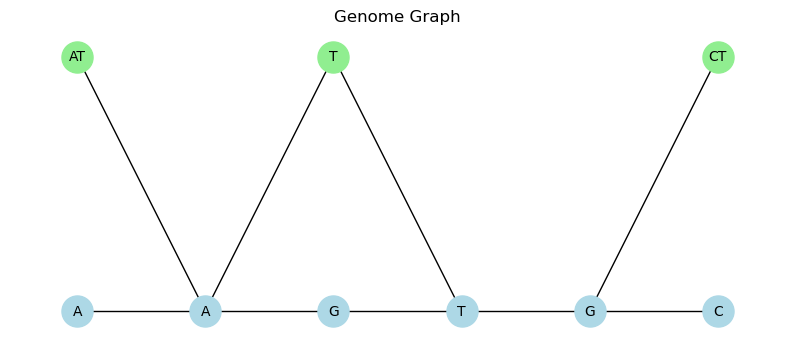

In [57]:
draw_genome_graph(G)

### PyG implementation

In [73]:
import torch
from torch_geometric.data import Data
import math

def create_reference_graph_pyg(reference, gene):
    """
    Build a reference backbone for the genome as an intermediate dictionary.
    Each base in the reference becomes a node with attributes:
      - position: the index (int)
      - nucleotide: the base (str)
      - type: "reference"
      - gene: gene name
    Returns:
      nodes: dictionary mapping node ID (as string) -> attributes
      edges: list of (source_node_id, target_node_id) tuples (as strings)
    """
    nodes = {}
    edges = []
    n = len(reference)
    
    # Create reference nodes (IDs are string versions of indices)
    for i, base in enumerate(reference):
        node_id = str(i)
        nodes[node_id] = {
            "position": i,
            "nucleotide": base,
            "type": "reference",
            "gene": gene
        }
    
    # Create edges for the linear backbone: "0" -- "1" -- ... -- "n-1"
    for i in range(n - 1):
        edges.append((str(i), str(i+1)))
    
    return nodes, edges

def add_variant(nodes, edges, reference, position, ref_seq, alt_seq, gene, beta=None, p_value=None, strand="+", direction="+"):
    """
    Add one variant bubble node that represents a mutation at 'position' which
    replaces ref_seq with alt_seq.
    
    For p > 0, add an edge from (p-1) -> variant node.
    For p == 0, do not add a left anchor.
    In both cases, if (p + len(ref_seq)) is within the reference,
    add an edge from the variant node -> (p + len(ref_seq)).
    
    The variant node is assigned attributes:
      - ref: reference allele (ref_seq)
      - alt: alternate allele (alt_seq)
      - alt_length: len(alt_seq)
      - ref_length: len(ref_seq)
      - position: starting position (p)
      - beta: beta value (or None)
      - log10_p: computed log10(p_value) if provided (or None)
      - strand: as given (default "+")
      - type: "variant"
      - direction: as given (default "+")
      - gene: gene name
    """
    n = len(reference)
    p = position
    
    # Create a unique variant node ID
    var_node_id = f"VAR_{p}_{ref_seq}->{alt_seq}"
    
    # Compute log10(p_value) if provided and positive
    log10_p = math.log10(p_value) if p_value is not None and p_value > 0 else None
    
    # Add the variant node to nodes dictionary
    nodes[var_node_id] = {
        "ref": ref_seq,
        "alt": alt_seq,
        "alt_length": len(alt_seq),
        "ref_length": len(ref_seq),
        "position": p,
        "beta": beta,
        "log10_p": log10_p,
        "strand": strand,
        "type": "variant",
        "direction": direction,
        "gene": gene
    }
    
    # Left anchor: if p > 0, add edge from (p-1) to variant node.
    if p > 0:
        edges.append((str(p-1), var_node_id))
    # p == 0: no left anchor is added.
    
    # Right anchor: compute end_anchor = p + len(ref_seq)
    end_anchor = p + len(ref_seq)
    if end_anchor < n:
        edges.append((var_node_id, str(end_anchor)))
    
def add_variants_to_graph(nodes, edges, reference, variants, gene):
    """
    For each variant (a dict with 'position', 'ref', 'alt', optionally 'beta', 'p', 'strand', 'direction'),
    add a variant bubble node to the existing nodes and edges.
    """
    for var in variants:
        p = var['position']
        ref_seq = var['ref']
        alt_seq = var['alt']
        # Basic safety check:
        if p < 0 or p >= len(reference):
            print(f"Warning: variant position {p} out of range.")
            continue
        beta = var.get("beta", None)
        p_value = var.get("p", None)
        strand = var.get("strand", "+")
        direction = var.get("direction", "+")
        
        add_variant(nodes, edges, reference, p, ref_seq, alt_seq, gene, beta, p_value, strand, direction)

def create_genome_graph_pyg(reference, variants, gene):
    """
    High-level function:
      1. Create the reference backbone (nodes and edges) for an undirected graph.
      2. Add variant bubble nodes and corresponding edges.
      3. Convert the intermediate representation into a PyG Data object.
    
    Returns a PyTorch Geometric Data object with:
      - x: Node feature matrix (using 'position' as a feature).
      - edge_index: Tensor of shape [2, num_edges].
      - node_info: Dictionary mapping original node IDs to attributes.
      - node_labels: Dictionary mapping PyG node index -> label,
                     where for reference nodes the label is 'nucleotide'
                     and for variant nodes the label is 'alt'.
    """
    # Step 1: Create reference backbone.
    nodes, edges = create_reference_graph_pyg(reference, gene)
    
    # Step 2: Add variants.
    add_variants_to_graph(nodes, edges, reference, variants, gene)
    
    # Step 3: Map node IDs (keys in `nodes`) to contiguous integer indices.
    node_ids = list(nodes.keys())
    node2index = {nid: idx for idx, nid in enumerate(node_ids)}
    
    # Create a feature matrix. For simplicity, we use the 'position' attribute.
    features = []
    node_labels = {}
    for nid in node_ids:
        attr = nodes[nid]
        features.append([attr["position"]])
        # For reference nodes, label = nucleotide; for variant nodes, label = alt.
        if attr.get("type") == "reference":
            node_labels[node2index[nid]] = attr.get("nucleotide", "")
        else:
            node_labels[node2index[nid]] = attr.get("alt", "")
    
    x = torch.tensor(features, dtype=torch.float)
    
    # Step 4: Convert edge list (using original node IDs) to an edge_index tensor.
    edge_index_list = []
    for src, tgt in edges:
        src_idx = node2index[src]
        tgt_idx = node2index[tgt]
        # Because the graph is undirected, we add both directions.
        edge_index_list.append([src_idx, tgt_idx])
        edge_index_list.append([tgt_idx, src_idx])
    
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    
    # Create the PyG Data object and attach extra attributes.
    data = Data(x=x, edge_index=edge_index)
    data.node_info = nodes  # Original attributes dictionary.
    data.node_labels = node_labels  # Mapping from PyG index -> label.
    data.index_to_nid = {node2index[nid]: nid for nid in node_ids}
    
    return data

In [74]:
# Example reference sequence.
reference_seq = "AAGTGC"  # length 6, indices 0..5
gene = "GeneX"

# Example variants.
variants = [
    # Variant at position 0: ref "A" -> alt "AT"
    {"position": 0, "ref": "A", "alt": "AT", "beta": 0.5, "p": 1e-5, "strand": "+", "direction": "+"},
    # Variant in the middle: position 2: ref "G" -> alt "T"
    {"position": 2, "ref": "G", "alt": "T", "beta": -0.3, "p": 1e-3, "strand": "+", "direction": "+"},
    # Variant at the end: position 5: ref "C" -> alt "CT"
    {"position": 5, "ref": "C", "alt": "CT", "beta": 0.8, "p": 1e-4, "strand": "+", "direction": "+"}
]

data = create_genome_graph_pyg(reference_seq, variants, gene)

print("Node features (x):")
print(data.x)
print("\nEdge index:")
print(data.edge_index)
print("\nNode labels:")
print(data.node_labels)
print(data.node_info)


Node features (x):
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [0.],
        [2.],
        [5.]])

Edge index:
tensor([[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 6, 1, 1, 7, 7, 3, 4, 8],
        [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 1, 6, 7, 1, 3, 7, 8, 4]])

Node labels:
{0: 'A', 1: 'A', 2: 'G', 3: 'T', 4: 'G', 5: 'C', 6: 'AT', 7: 'T', 8: 'CT'}
{'0': {'position': 0, 'nucleotide': 'A', 'type': 'reference', 'gene': 'GeneX'}, '1': {'position': 1, 'nucleotide': 'A', 'type': 'reference', 'gene': 'GeneX'}, '2': {'position': 2, 'nucleotide': 'G', 'type': 'reference', 'gene': 'GeneX'}, '3': {'position': 3, 'nucleotide': 'T', 'type': 'reference', 'gene': 'GeneX'}, '4': {'position': 4, 'nucleotide': 'G', 'type': 'reference', 'gene': 'GeneX'}, '5': {'position': 5, 'nucleotide': 'C', 'type': 'reference', 'gene': 'GeneX'}, 'VAR_0_A->AT': {'ref': 'A', 'alt': 'AT', 'alt_length': 2, 'ref_length': 1, 'position': 0, 'beta': 0.5, 'log10_p': -5.0, 'strand': '+', 'type': 'vari

### PyG Visualization

In [89]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_genome_graph_pyg(data):
    """
    Visualize a PyG Data object representing a genome graph.
    
    Layout:
      - x-coordinate: node's "position" (retrieved from data.node_info)
      - y-coordinate: 0 for reference nodes, 1 for variant nodes.
      
    Node labels:
      - Reference nodes display the 'nucleotide' attribute.
      - Variant nodes display the 'alt' attribute.
    
    Variant nodes are drawn in light green; reference nodes in light blue.
    Edges are drawn without arrows.
    """
    # Convert PyG Data to a NetworkX graph (without specifying node_info)
    G = to_networkx(data)
    
    # Build custom layout using our stored attributes.
    pos = {}
    for node in G.nodes():
        # Retrieve the original node ID using our mapping.
        orig_id = data.index_to_nid[node]
        attr = data.node_info[orig_id]
        x_coord = attr.get("position", 0)
        y_coord = 0 if attr.get("type") == "reference" else 1
        pos[node] = (x_coord, y_coord)
    
    # Separate nodes by type for coloring.
    ref_nodes = []
    variant_nodes = []
    for node in G.nodes():
        orig_id = data.index_to_nid[node]
        node_type = data.node_info[orig_id].get("type")
        if node_type == "reference":
            ref_nodes.append(node)
        else:
            variant_nodes.append(node)
    
    # Build labels: reference nodes use 'nucleotide'; variant nodes use 'alt'.
    labels = {}
    for node in G.nodes():
        orig_id = data.index_to_nid[node]
        attr = data.node_info[orig_id]
        if attr.get("type") == "reference":
            labels[node] = attr.get("nucleotide", "")
        else:
            labels[node] = attr.get("alt", "")
    
    plt.figure(figsize=(10, 4))
    nx.draw_networkx_nodes(G, pos, nodelist=ref_nodes, node_color='lightblue', node_size=500, label="Reference")
    nx.draw_networkx_nodes(G, pos, nodelist=variant_nodes, node_color='lightgreen', node_size=500, label="Variant")
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    nx.draw_networkx_edges(G, pos, arrows=False)
    
    plt.title("Genome Graph")
    plt.axis("off")
    plt.show()


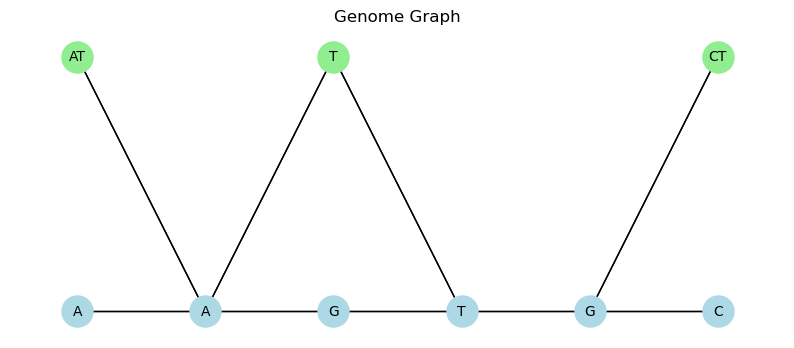

In [90]:
visualize_genome_graph_pyg(data)

### Data compression + export

In [85]:
import torch
import gzip

# Save and compress the data
with gzip.open("graph_data.pt.gz", "wb") as f:
    torch.save(data, f)

### decompress + open data

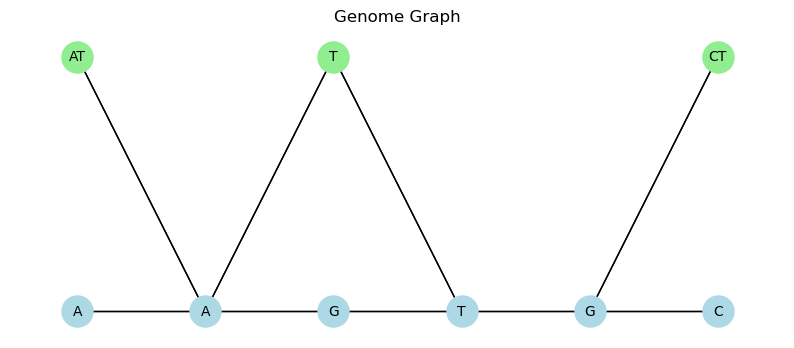

In [91]:
with gzip.open("graph_data.pt.gz", "rb") as f:
    loaded_data = torch.load(f, weights_only=False)

# plot loaded data 
visualize_genome_graph_pyg(loaded_data)

# WORKS! 

### start pipeline now

We want to filter our mutation data to only include mutations that are in the reference gene

We need two things:

1. A **function** to read in a FASTA file to return the start position, end position, and sequence
2. Filtered mutation data 
3. A **function** to allow the PyG graph generation to take in the data from this dataframe

### 1. Read in a FASTA file to return the start position, end position, and sequence

In [100]:
def parse_fasta(fasta_file_path):
    """
    Parse a FASTA file to extract position information and sequence.
    
    Args:
        fasta_file_path (str): Path to the FASTA file
        
    Returns:
        tuple: (start_position, end_position, sequence_string)
    """
    header = ""
    sequence_lines = []
    
    # Read the file
    with open(fasta_file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                header = line[1:]  # Remove the '>' character
            else:
                sequence_lines.append(line)
    
    # Extract positions from header
    # Looking for the pattern: c133275201-133250401
    import re
    position_match = re.search(r'c(\d+)-(\d+)', header)
    if position_match:
        start_position = position_match.group(1)
        end_position = position_match.group(2)
    else:
        start_position = None
        end_position = None
    
    # Join all sequence lines into a single string
    full_sequence = ''.join(sequence_lines)
    
    return int(start_position), int(end_position), full_sequence

In [101]:
start_pos, end_pos, sequence = parse_fasta('input/sequence.fasta')

start_pos, end_pos, sequence

(133275201,
 133250401,
 'AGACGCGGAGCCATGGCCGAGGTGTTGCGGACGCTGGCCGGTGAGTGCAGGCCTCGGCCCCGGGTGCCCGCGAGGGAGCCGCTACCGCAGGGAATGCGGGGTGCACCCGACAGCCGGGCCGGGGTGGGGGCGCTCAGGGCTGCGAGGCTTCGGGCCGGCCGCCGCCCCAGCCTCCGAGACCCTGCGTCCTGGGGAGCCGGCGGGCAGGTGGGCTCGGCCGCGCTGTGGGTGCCTGGGACCCGCAGGGAGGATGGGCGCGGTGGCGCGGCCTGGCGGGGGGCTCGTCTCCGGGGTCCCCGGGTCCTGGTGAGAGCGGGGTCCCTCGACGCCGTGGCGGTCTCCAGCCTCTCCTCGCCCCTCCACGCTCCCCGCCTTCCATGAGCTGCTATTTTCAGCACCTACCGCCCGACCCTGGACTAGGACAAGGCTCTGGGCTGCCCTGCCCGCCCCCCAGCCCTTCCCTCGGGCACGGCGGCCAGGCGCCCGGGTTGACCGGGAACAGCCTCCATACCCCAAACGCGGAGGCGCCTCGGGAAGGCGAGGTGGGCAAGTTCAATGCCAAGCGTGACGGGGGAACTGTGCCCCGGGCCCTCAGGTGATATAGGAGTTAAGAAGAAATTATTGAGGCAACCAGATGCGGTGACTCAGGCCTGTAACCCCAGCACTTTGGGAGGCCGAGGGTGGATCACCTGTCCTTAATTTTCTTGGCGCCAGAAGATGAATTGAGTATTTACCCAGACAACAACGTCGCTTCAGAGGGAGGGATGCAGAACGCAGGGCCACGGGGTGCAGGCTGCAGGCCAGTGAACCCCAACGCCAAAGGCCAGGGAGAGCCGGGTGGGGTACCCAGAGCCAGCACACAGCCCTTTAATTTAGAGGAGTGCTGTGTACACATCTGGGGAGAGATGTTTTACTTTGATTTGGAATCAGGTGGCGGATAAGGCATACTGAGGCCTGACTTGGTGAGGGCTCCT

### Let's filter mutation data

In [113]:
import pandas as pd
import re 

c9 = pd.read_csv('ABO_P16442_OID30675_v1_Inflammation_II/combined_chr9_ABO:P16442:OID30675:v1:Inflammation_II', delimiter=' ')

# filter by info > 0.7
c9 = c9[c9['INFO'] > 0.7]

# remove GENPOS column because it is wrong 
c9 = c9.drop(columns=['GENPOS'])

# Extract POSITION from ID (format: CHR:POSITION:ALLELE0:ALLELE1:INFO)
def extract_position(id_str):
    match = re.match(r'[^:]+:(\d+):.*', str(id_str))  # Ensure ID is string
    return int(match.group(1)) if match else None

c9["POSITION"] = c9["ID"].apply(extract_position)

# keep mutations that are in the reference gene
# NOTE: BE CAREFUL this is a case where start_pos > end_pos (transcribed backwards?)
c9 = c9[c9['POSITION'] >= end_pos]
c9 = c9[c9['POSITION'] <= start_pos]

# we now have all the mutations inside the reference gene
ref_gene = c9.reset_index(drop=True)
ref_gene.head()

,CHROM,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,POSITION
0,9,9:133250548:A:G:imp:v1,A,G,0.399292,0.863965,97,ADD,0.258217,0.218645,1.394730,0.624140,NaN,133250548
1,9,9:133250763:G:A:imp:v1,G,A,0.103779,0.960756,97,ADD,0.086090,0.275972,0.097313,0.122008,NaN,133250763
2,9,9:133251128:C:T:imp:v1,C,T,0.482029,0.943493,97,ADD,-0.034310,0.165126,0.043173,0.078106,NaN,133251128
3,9,9:133251562:A:T:imp:v1,A,T,0.696119,1.092260,97,ADD,-0.161229,0.191522,0.708675,0.398066,NaN,133251562
4,9,9:133251986:T:C:imp:v1,T,C,0.696321,1.095110,97,ADD,-0.161671,0.190953,0.716825,0.401004,NaN,133251986


### Final PyG graph generation using the filtered mutation data

In [117]:
import torch
from torch_geometric.data import Data
import math

def create_reference_graph_pyg(reference, gene, start_index=0):
    """
    Build a reference backbone for the genome as an intermediate dictionary.
    Each base in the reference becomes a node with attributes:
      - position: global genomic coordinate = start_index + i
      - local_index: i (optional, for debugging)
      - nucleotide: the base (str)
      - type: "reference"
      - gene: gene name

    Returns:
      nodes: dict mapping node ID (str) -> attributes
      edges: list of (source_node_id, target_node_id) (both strings)
    """
    nodes = {}
    edges = []
    n = len(reference)
    
    # Create reference nodes with global position = start_index + i
    for i, base in enumerate(reference):
        global_pos = start_index + i
        node_id = str(i)  # local index as the node ID
        nodes[node_id] = {
            "position": global_pos,  # global genomic coordinate
            "local_index": i,
            "nucleotide": base,
            "type": "reference",
            "gene": gene
        }
    
    # Create edges for the linear backbone: "0" -- "1" -- ... -- "n-1"
    for i in range(n - 1):
        edges.append((str(i), str(i+1)))
    
    return nodes, edges

def add_variant(
    nodes, edges, reference,
    global_p,        # The global genomic position
    ref_seq, alt_seq,
    gene,
    beta=None, log10_p=None,
    strand="+", direction="+",
    start_index=0
):
    """
    Add one variant bubble node for a mutation at global position `global_p`.
    The local index is computed as local_p = global_p - start_index.

    For local_p > 0, add an edge from (local_p-1) -> variant node (undirected).
    If (local_p + len(ref_seq)) < len(reference), connect variant node -> (local_p + len(ref_seq)).

    The variant node is assigned attributes:
      - position: global_p  (the actual genomic coordinate)
      - ref, alt, alt_length, ref_length
      - beta, log10_p
      - strand, direction, gene
      - type: "variant"
    """
    n = len(reference)
    local_p = global_p - start_index  # convert global to local index
    
    # Safety check: is the variant local index within the reference?
    if local_p < 0 or local_p >= n:
        print(f"Warning: variant position {global_p} (local={local_p}) out of range.")
        return
    
    var_node_id = f"VAR_{global_p}_{ref_seq}->{alt_seq}"
    
    nodes[var_node_id] = {
        "position": global_p,         # store the global position
        "ref": ref_seq,
        "alt": alt_seq,
        "alt_length": len(alt_seq),
        "ref_length": len(ref_seq),
        "beta": beta,
        "log10_p": log10_p,
        "strand": strand,
        "direction": direction,
        "type": "variant",
        "gene": gene
    }
    
    # Left anchor: if local_p > 0, connect (local_p-1) -> variant node
    if local_p > 0:
        edges.append((str(local_p-1), var_node_id))
    
    # Right anchor: skip over len(ref_seq) bases in the reference
    end_anchor = local_p + len(ref_seq)
    if end_anchor < n:
        edges.append((var_node_id, str(end_anchor)))

def add_variants_to_graph(
    nodes, edges,
    reference, variants, gene,
    start_index=0
):
    """
    For each variant in `variants` (list of dicts with:
      - position (global coordinate)
      - ref, alt
      - beta, log10_p
      - strand, direction
    ), add a variant bubble node to the existing nodes & edges.
    """
    for var in variants:
        global_p = var['position']
        ref_seq = var['ref']
        alt_seq = var['alt']
        
        add_variant(
            nodes, edges, reference,
            global_p=global_p,
            ref_seq=ref_seq, alt_seq=alt_seq,
            gene=gene,
            beta=var.get("beta", None),
            log10_p=var.get("log10_p", None),
            strand=var.get("strand", "+"),
            direction=var.get("direction", "+"),
            start_index=start_index
        )

def create_genome_graph_pyg(
    reference,
    variants,
    gene,
    start_index=0
):
    """
    1) Create the reference backbone (undirected) with global positions = start_index + i.
    2) Add variant bubble nodes, which use local indexing for edges but store global positions.
    3) Convert to a PyG Data object.
    """
    # Step 1: Create reference backbone
    nodes, edges = create_reference_graph_pyg(reference, gene, start_index=start_index)
    
    # Step 2: Add variants
    add_variants_to_graph(nodes, edges, reference, variants, gene, start_index=start_index)
    
    # Step 3: Map node IDs to contiguous int indices
    node_ids = list(nodes.keys())
    node2index = {nid: idx for idx, nid in enumerate(node_ids)}
    
    # Build feature matrix from the node's "position" attribute (the global coordinate)
    features = []
    node_labels = {}
    for nid in node_ids:
        attr = nodes[nid]
        features.append([attr["position"]])  # store the global position as the feature
        if attr.get("type") == "reference":
            node_labels[node2index[nid]] = attr.get("nucleotide", "")
        else:
            node_labels[node2index[nid]] = attr.get("alt", "")
    
    import torch
    from torch_geometric.data import Data
    
    x = torch.tensor(features, dtype=torch.float)
    
    # Convert edges to edge_index
    edge_index_list = []
    for src, tgt in edges:
        src_idx = node2index[src]
        tgt_idx = node2index[tgt]
        # Undirected => both directions
        edge_index_list.append([src_idx, tgt_idx])
        edge_index_list.append([tgt_idx, src_idx])
    
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    
    data = Data(x=x, edge_index=edge_index)
    data.node_info = nodes
    data.node_labels = node_labels
    data.index_to_nid = {node2index[nid]: nid for nid in node_ids}
    
    return data


def df_to_variants(df, gene):
    """
    Convert each row in df into a variant dict suitable for create_genome_graph_pyg.
    
    Expected columns in df:
      - ALLELE0 -> ref
      - ALLELE1 -> alt
      - POSITION -> position
      - BETA -> beta
      - LOG10P -> log10_p
      - (optional) strand
      - (optional) direction
    
    Parameters:
        df (pd.DataFrame): The table of variants.
        gene (str): Gene name or identifier.
    
    Returns:
        list of dict: Each dict has keys:
                      ['position', 'ref', 'alt', 'beta', 'log10_p', 'strand', 'direction', 'gene'].
    """
    variants = []
    for _, row in df.iterrows():
        variant = {
            "position": row["POSITION"],     # 0-based index
            "ref": row["ALLELE0"],
            "alt": row["ALLELE1"],
            "beta": row["BETA"],
            "log10_p": row["LOG10P"],
            # If your DataFrame doesn't have these columns, default to "+"
            "strand": row.get("strand", "+"), # TODO: STILL NEED TO FIX THIS DEPENDING ON HOW THE DATA IS STORED
            "direction": row.get("direction", "+"),
            "gene": gene
        }
        variants.append(variant)
    return variants

In [118]:
# create variants list from dataframe 
variants_list = df_to_variants(ref_gene, "ABO")

# create genome graph
data = create_genome_graph_pyg(sequence, variants_list, "ABO", start_index=end_pos)


In [119]:
data.node_info

{'0': {'position': 133250401,
  'local_index': 0,
  'nucleotide': 'A',
  'type': 'reference',
  'gene': 'ABO'},
 '1': {'position': 133250402,
  'local_index': 1,
  'nucleotide': 'G',
  'type': 'reference',
  'gene': 'ABO'},
 '2': {'position': 133250403,
  'local_index': 2,
  'nucleotide': 'A',
  'type': 'reference',
  'gene': 'ABO'},
 '3': {'position': 133250404,
  'local_index': 3,
  'nucleotide': 'C',
  'type': 'reference',
  'gene': 'ABO'},
 '4': {'position': 133250405,
  'local_index': 4,
  'nucleotide': 'G',
  'type': 'reference',
  'gene': 'ABO'},
 '5': {'position': 133250406,
  'local_index': 5,
  'nucleotide': 'C',
  'type': 'reference',
  'gene': 'ABO'},
 '6': {'position': 133250407,
  'local_index': 6,
  'nucleotide': 'G',
  'type': 'reference',
  'gene': 'ABO'},
 '7': {'position': 133250408,
  'local_index': 7,
  'nucleotide': 'G',
  'type': 'reference',
  'gene': 'ABO'},
 '8': {'position': 133250409,
  'local_index': 8,
  'nucleotide': 'A',
  'type': 'reference',
  'gene': 

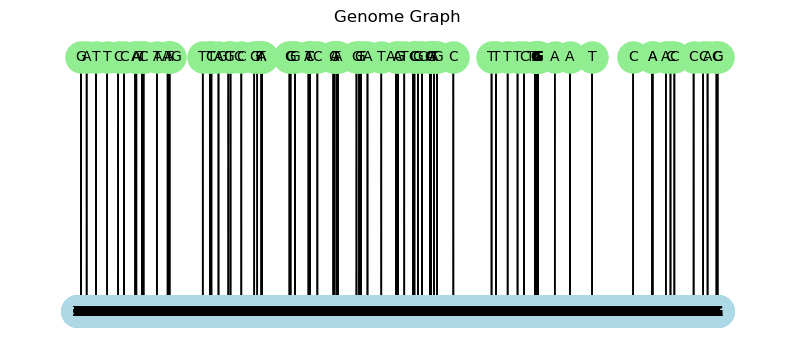

In [120]:
visualize_genome_graph_pyg(data)